# **Model Selection**

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from xgboost import XGBRegressor, plot_importance

import shap

## Load Dataset

In [2]:
df = pd.read_csv('train.csv')

## Explore the Data

In [3]:
df.shape

(1458644, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [5]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
df['dropoff_datetime'].min()

'2016-01-01 00:03:31'

In [7]:
df['dropoff_datetime'].max()

'2016-07-01 23:02:03'

In [8]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [9]:
(df.isnull().sum()/(len(df)))*100

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [10]:
df.nunique()

id                    1458644
vendor_id                   2
pickup_datetime       1380222
dropoff_datetime      1380377
passenger_count            10
pickup_longitude        23047
pickup_latitude         45245
dropoff_longitude       33821
dropoff_latitude        62519
store_and_fwd_flag          2
trip_duration            7417
dtype: int64

In [11]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,1458644.0,1.534950,0.498777,1.000000,1.000000,2.000000,2.000000,2.000000e+00
passenger_count,1458644.0,1.664530,1.314242,0.000000,1.000000,1.000000,2.000000,9.000000e+00
pickup_longitude,1458644.0,-73.973486,0.070902,-121.933342,-73.991867,-73.981743,-73.967331,-6.133553e+01
pickup_latitude,1458644.0,40.750921,0.032881,34.359695,40.737347,40.754101,40.768360,5.188108e+01
dropoff_longitude,1458644.0,-73.973416,0.070643,-121.933304,-73.991325,-73.979752,-73.963013,-6.133553e+01
dropoff_latitude,1458644.0,40.751800,0.035891,32.181141,40.735885,40.754524,40.769810,4.392103e+01
trip_duration,1458644.0,959.492273,5237.431724,1.000000,397.000000,662.000000,1075.000000,3.526282e+06


## Preliminary Feature Engineering

### Create new features from pickup_datetime and dropoff_datetime

In [12]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

In [13]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_month'] = df['pickup_datetime'].dt.month

In [14]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,0,17,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,2,19,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,5,13,3


### Calculate Haversine great-circle distance

In [15]:
def calculate_haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the great-circle distance between two points
    on a sphere given their longitudes and latitudes.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])    
    dlon = lon2 - lon1
    dlat = lat2 - lat1   
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6378.137 * c
    
    return haversine_distance

In [16]:
df['haversine_distance'] = calculate_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,0,17,3,1.500199
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,0,6,1.807530
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,11,1,6.392251
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,2,19,4,1.487163
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,5,13,3,1.189920


### Calculate Manhattan distance

In [17]:
def calculate_manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Calculates Manhattan distance between two points using their latitude and longitude.
    """
    a = calculate_haversine_distance(lat1, lon1, lat1, lon2)
    b = calculate_haversine_distance(lat1, lon1, lat2, lon1)
    manhattan_distance = a + b
    
    return manhattan_distance

In [18]:
df['manhattan_distance'] = df.apply(lambda row: calculate_manhattan_distance(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,Monday,0,17,3,1.500199,1.737377
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,Sunday,6,0,6,1.807530,2.433229
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,Tuesday,1,11,1,6.392251,8.212765
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,Wednesday,2,19,4,1.487163,1.663192
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,Saturday,5,13,3,1.189920,1.200800


### Convert latitude and longitude to Polar coordinates

In [19]:
def convert_to_polar_coordinates(lat, lon):
    """
    Converts latitude and longitude to polar coordinates.
    """
    # Convert latitude and longitude from degrees to radians
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)

    # Convert to polar coordinates
    r = math.sqrt(lat_rad**2 + lon_rad**2)
    phi = math.atan2(lon_rad, lat_rad)

    return r, phi

In [20]:
df['pickup_r'], df['pickup_phi'] = zip(*df.apply(lambda row: convert_to_polar_coordinates(row['pickup_latitude'], row['pickup_longitude']), axis=1))
df['dropoff_r'], df['dropoff_phi'] = zip(*df.apply(lambda row: convert_to_polar_coordinates(row['dropoff_latitude'], row['dropoff_longitude']), axis=1))

In [21]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,0,17,3,1.500199,1.737377,1.474301,-1.067147,1.474013,-1.067071
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,6,0,6,1.807530,2.433229,1.474027,-1.067441,1.474256,-1.067627
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,1,11,1,6.392251,8.212765,1.474219,-1.067170,1.474168,-1.067879
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2,19,4,1.487163,1.663192,1.474323,-1.067803,1.474246,-1.067953
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,5,13,3,1.189920,1.200800,1.474374,-1.066833,1.474282,-1.066943


### Calculate bearing

In [22]:
def calculate_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates bearing between two points using their latitude and longitude.
    """
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Calculate the difference in longitudes
    dlon = lon2 - lon1

    # Calculate the bearing angle
    x = np.sin(dlon) * np.cos(lat2)
    y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(dlon))
    initial_bearing = np.arctan2(x, y)

    # Normalize the initial bearing to 0° ... 360°
    initial_bearing = np.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [23]:
df['bearing'] = df.apply(lambda row: calculate_bearing(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,17,3,1.500199,1.737377,1.474301,-1.067147,1.474013,-1.067071,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6,0,6,1.807530,2.433229,1.474027,-1.067441,1.474256,-1.067627,242.846232
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,1,11,1,6.392251,8.212765,1.474219,-1.067170,1.474168,-1.067879,200.319835
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2,19,4,1.487163,1.663192,1.474323,-1.067803,1.474246,-1.067953,187.262300
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5,13,3,1.189920,1.200800,1.474374,-1.066833,1.474282,-1.066943,179.473585


## Outlier Handling

### Passenger count

In [24]:
df = df[df['passenger_count'] > 0]
df = df[df['passenger_count'] < 7]

### Lonitude and latitude

In [25]:
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['pickup_longitude'] >= -74.03]
df = df[df['pickup_latitude'] <= 40.85]
df = df[df['pickup_latitude'] >= 40.63]
df = df[df['dropoff_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] >= -74.03]
df = df[df['dropoff_latitude'] <= 40.85]
df = df[df['dropoff_latitude'] >= 40.63]

### Trip duration - Target

In [26]:
df['trip_duration'].mean() / 60

15.769938504513142

In [27]:
df['trip_duration_zscore'] = (df['trip_duration'] - df['trip_duration'].mean())/df['trip_duration'].std(ddof=0)
df.sort_values(by=['trip_duration_zscore'], ascending=False).head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing,trip_duration_zscore
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,22,2,19.922955,27.722957,1.470265,-1.067251,1.474092,-1.067308,304.641003,671.331806
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,6,1,1.636959,1.774151,1.474110,-1.067422,1.474013,-1.067583,185.030076,424.025301
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,22,2,5.989189,8.072751,1.473101,-1.067140,1.474273,-1.067244,297.381354,390.122180
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,0,1,20.171235,28.538433,1.470310,-1.067337,1.473957,-1.066948,315.683698,369.204902
1234291,id1942836,2,2016-02-15 23:18:06,2016-02-16 23:17:58,2,-73.794525,40.644825,-73.991051,40.755573,N,...,23,2,20.665848,28.927971,1.470395,-1.067352,1.474332,-1.067326,306.688034,16.271496


In [28]:
df = df[df['trip_duration_zscore'] < 2]
df.drop(['trip_duration_zscore'], axis=1, inplace=True)

## Feature Correlations (Numerical Features)

In [29]:
numeric = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numeric)
df_numeric.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_weekday,pickup_hour,pickup_month,haversine_distance,manhattan_distance,pickup_r,pickup_phi,dropoff_r,dropoff_phi,bearing
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,0,17,3,1.500199,1.737377,1.474301,-1.067147,1.474013,-1.067071,99.970196
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,0,6,1.807530,2.433229,1.474027,-1.067441,1.474256,-1.067627,242.846232
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,11,1,6.392251,8.212765,1.474219,-1.067170,1.474168,-1.067879,200.319835
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,2,19,4,1.487163,1.663192,1.474323,-1.067803,1.474246,-1.067953,187.262300
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,5,13,3,1.189920,1.200800,1.474374,-1.066833,1.474282,-1.066943,179.473585


<Axes: >

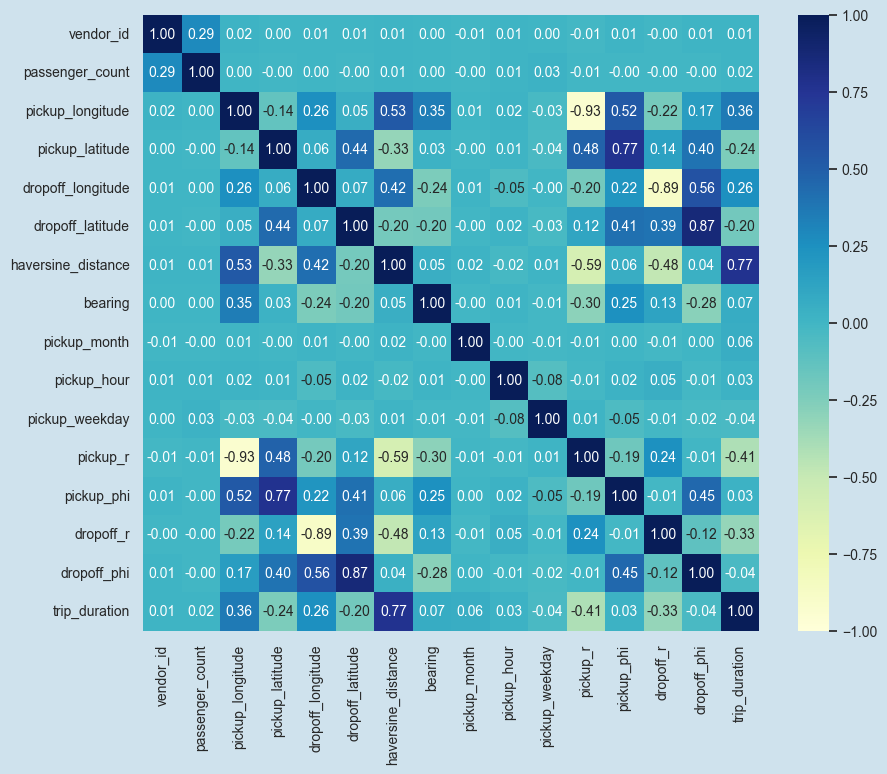

In [30]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(10, 8), 'grid.linestyle': '--'})

num_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'haversine_distance', 'bearing', 'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_r', 'pickup_phi', 'dropoff_r', 'dropoff_phi']
num_features_target = copy.copy(num_features)
num_features_target.append('trip_duration')
sns.heatmap(data=df[num_features_target].corr(), square=True, annot=True, annot_kws={'size': 10}, fmt=".2f", vmin=-1, vmax=1, cmap="YlGnBu")

## Train Various Regression Models and Select a First Candidate

In [31]:
num_features = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
                'haversine_distance', 'bearing', 'pickup_month', 'pickup_hour', 'pickup_weekday', 'pickup_r', 'pickup_phi', 'dropoff_r', 'dropoff_phi']
# cat_features = ['pickup_day']
features = num_features
target = 'trip_duration'

In [32]:
y = df[target]
X = df[features]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)

In [34]:
model_dt = DecisionTreeRegressor(random_state=10)
model_dt.fit(X_train, y_train)
predictions_dt = model_dt.predict(X_test)
print('Decision Tree Regression Performance Metrics')
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_dt, y_test)))
print("Mean Squared Error: " + str(mean_squared_error(predictions_dt, y_test)))
print("Root Mean Squared Error: " + str(root_mean_squared_error(predictions_dt, y_test)))
print("R^2: " + str(r2_score(predictions_dt, y_test)))

Decision Tree Regression Performance Metrics
Mean Absolute Error: 254.15556545216688
Mean Squared Error: 176917.30160116346
Root Mean Squared Error: 420.6153844085633
R^2: 0.5922970178203708


In [35]:
model_rf = RandomForestRegressor(n_estimators=10, verbose=2, random_state=10)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)
print('Random Forest Regression Performance Metrics')
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_rf, y_test)))
print("Mean Squared Error: " + str(mean_squared_error(predictions_rf, y_test)))
print("Root Mean Squared Error: " + str(root_mean_squared_error(predictions_rf, y_test)))
print("R^2: " + str(r2_score(predictions_rf, y_test)))

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Random Forest Regression Performance Metrics
Mean Absolute Error: 189.76037493853275
Mean Squared Error: 93036.9275964729
Root Mean Squared Error: 305.0195528100992
R^2: 0.7315259758840837


In [36]:
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=10)
model_xgb.fit(X_train, y_train)
predictions_xgb = model_xgb.predict(X_test)
print('XGBoost Regression Performance Metrics')
print("Mean Absolute Error: " + str(mean_absolute_error(predictions_xgb, y_test)))
print("Mean Squared Error: " + str(mean_squared_error(predictions_xgb, y_test)))
print("Root Mean Squared Error: " + str(root_mean_squared_error(predictions_xgb, y_test)))
print("R^2: " + str(r2_score(predictions_xgb, y_test)))

XGBoost Regression Performance Metrics
Mean Absolute Error: 171.57113266101703
Mean Squared Error: 79266.23168743195
Root Mean Squared Error: 281.5425930253395
R^2: 0.7637947220827415


## XGBoost Feature Importances

#### Global feature importance calcuations are included with XGBoost library. But they calculate feature importances based on different importace types: Weight, Gain and Cover.
#### This could lead to inconsistency in calculating feature importances since one of the types needs to be selected based on reasoning that could change over time.
#### To resolve this, a SHAP (SHapley Additive exPlanations) concept is used. SHAP is a game theoretic approach to explain the output of any machine learning model.

Text(0.5, 1.0, 'Feature Importance (Importance Type: Weight)')

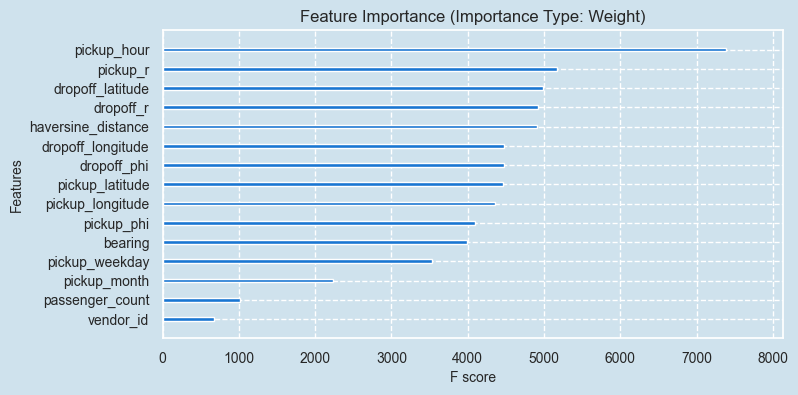

In [37]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model_xgb, importance_type='weight', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Weight)')

Text(0.5, 1.0, 'Feature Importance (Importance Type: Gain)')

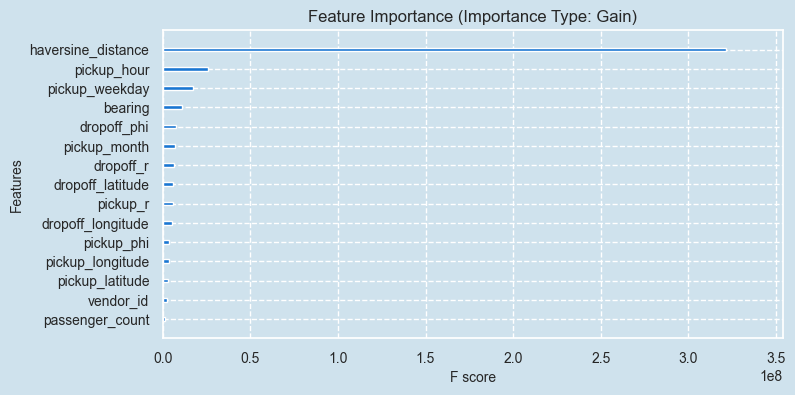

In [38]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model_xgb, importance_type='gain', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Gain)')

Text(0.5, 1.0, 'Feature Importance (Importance Type: Cover)')

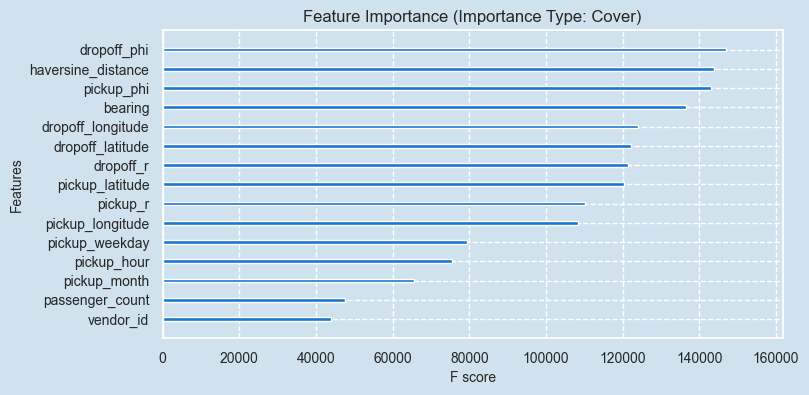

In [39]:
sns.set(rc={'axes.facecolor':'#cfe2ed', 'figure.facecolor':'#cfe2ed', 'font.style':'normal', 'axes.edgecolor': 'white', 'axes.titlesize':10, 'axes.grid':True, 'axes.titlesize': 12, 'axes.labelsize':10,
            'xtick.labelsize':10, 'ytick.labelsize':10, 'figure.figsize':(8, 4), 'grid.linestyle': '--'})

plot_importance(model_xgb, importance_type='cover', show_values=False, color="#1976d2")
plt.title('Feature Importance (Importance Type: Cover)')

## SHAP Feature Importances

In [40]:
# Load JS visualization code to notebook
# shap.initjs()

In [41]:
X_sampled = X_train.sample(frac=0.01, random_state=10)

In [42]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(model_xgb)
shap_values = explainer(X_sampled)

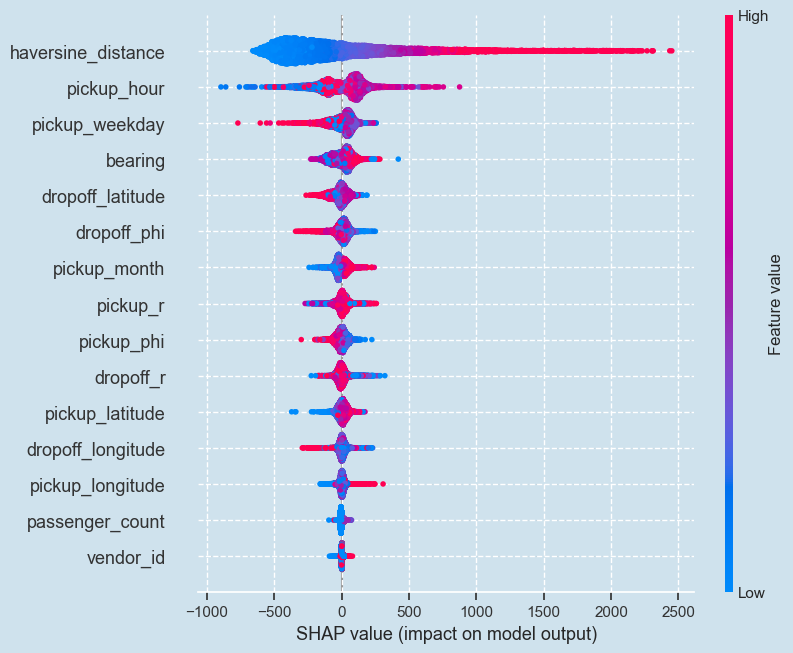

In [43]:
# Summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(features))

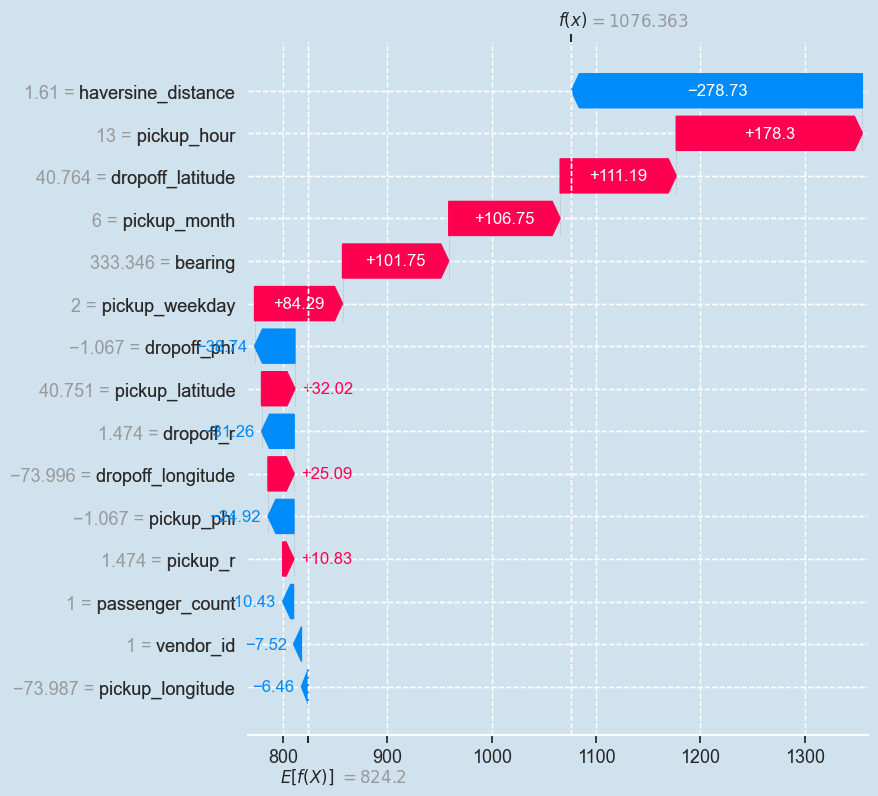

In [44]:
# Visualize the model v0 prediction's explanation
shap.plots.waterfall(shap_values[0], max_display=len(features))

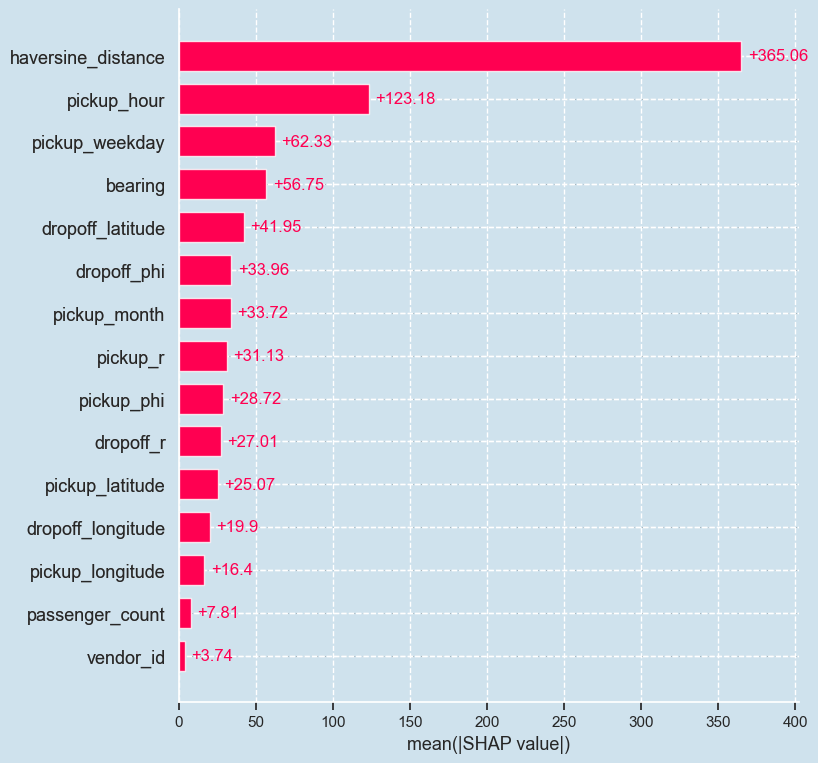

In [45]:
# Feature importance bar chart
shap.plots.bar(shap_values, max_display=len(features))

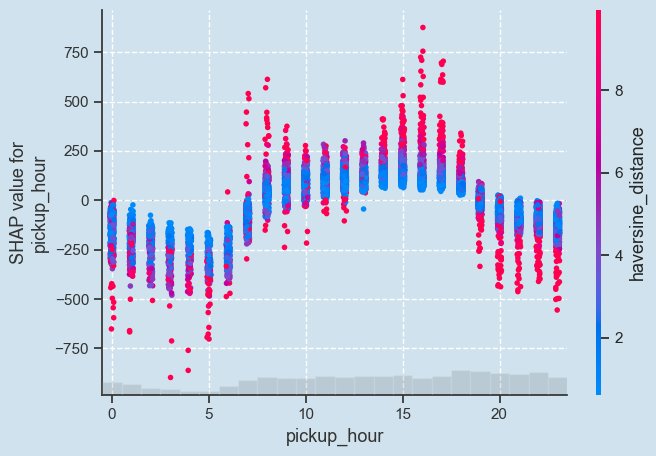

In [46]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
shap.plots.scatter(shap_values[:, "pickup_hour"], color=shap_values)